In [8]:
import numpy as np
from skimage import io, util, measure, transform
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import pandas as pd
from imageUtils import normalize_image_intensity_signed

from os import path
import stackview
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator

from measurements import get_mesh_from_bm_image,get_tissue_curvatures
from trimesh import Trimesh
import pyvista as pv
pv.set_jupyter_backend('trame')

In [2]:

# dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/F1 cage 3015 MemGFP NoFUCCI/R2/'
dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/10-03-2025 Cdh5-RFP blood vessels/Male 6121/Left paw R1'

t0 = io.imread(path.join(dirname,'0. Day 0/height_image.tif'))
t1 = io.imread(path.join(dirname,'1. Day 11/height_image.tif'))

stackview.orthogonal(t0, zoom_factor=0.5,continuous_update=True)


In [3]:
dx = 0.2919921875
dz = 0.7

#Trim to the 'center' to avoid the artifacts on edges
Y_trim = slice(100,900)
X_trim = slice(100,900)
t0_crop = t0[:,Y_trim,X_trim]
t1_crop = t1[:,Y_trim,X_trim]

gridY,gridX = np.meshgrid(range(800),range(800))

t0_mesh = get_mesh_from_bm_image(t0_crop,spacing=[dz,dx,dx])
t0_curvature,_ = get_tissue_curvatures(t0_mesh,kappa=6)

t1_mesh = get_mesh_from_bm_image(t1_crop,spacing=[dz,dx,dx])
t1_curvature,_ = get_tissue_curvatures(t1_mesh,kappa=6)


In [ ]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(t0_mesh)
pl.show(jupyter_backend='trame')

In [ ]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(t1_mesh)
pl.show(jupyter_backend='trame')

In [ ]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.subplot(1,2,1)
plt.scatter(t0_mesh.vertices[:,0],
            t0_mesh.vertices[:,1],
            c=t0_curvature,s=3,alpha=0.5)
plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(t1_mesh.vertices[:,0],
            t1_mesh.vertices[:,1],
            c=t1_curvature,s=3,alpha=0.5)
plt.colorbar()

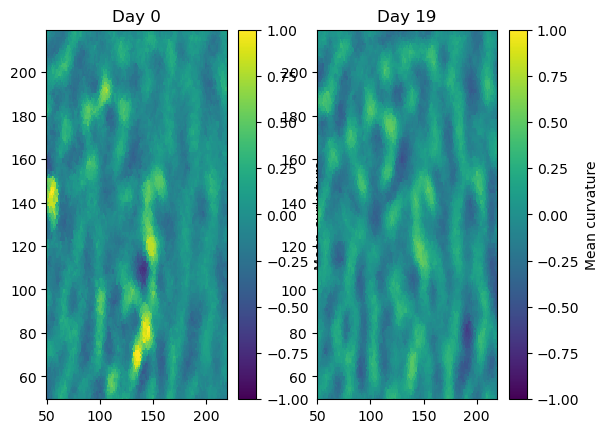

In [15]:
interp = NearestNDInterpolator(list(zip(t0_mesh.vertices[:,0], t0_mesh.vertices[:,1])), t0_curvature)
plt.subplot(1,2,1)
plt.title('Day 0')
gridY,gridX = np.meshgrid( np.arange(50,220),np.arange(50,220))
t0_curve_grid = interp( gridY,gridX )
plt.pcolor(gridX,gridY,t0_curve_grid)
plt.clim([-1,1])
plt.colorbar(label='Mean curvature')

interp = NearestNDInterpolator(list(zip(t1_mesh.vertices[:,0], t1_mesh.vertices[:,1])), t1_curvature)
plt.subplot(1,2,2)
plt.title('Day 19')
gridY,gridX = np.meshgrid( np.arange(50,220),np.arange(50,220))
t1_curve_grid = interp( gridY,gridX)
plt.pcolor(gridX,gridY,t1_curve_grid)
plt.clim([-1,1])

plt.colorbar(label='Mean curvature')

In [28]:
# Export curvature images
io.imsave(path.join(dirname,'0. Day 0/curvature.tif'),util.img_as_int(normalize_image_intensity_signed(t0_curve_grid)))
io.imsave(path.join(dirname,'1. Day 11/curvature.tif'),util.img_as_int(normalize_image_intensity_signed(t1_curve_grid)))

np.float64(0.5247783608540215)

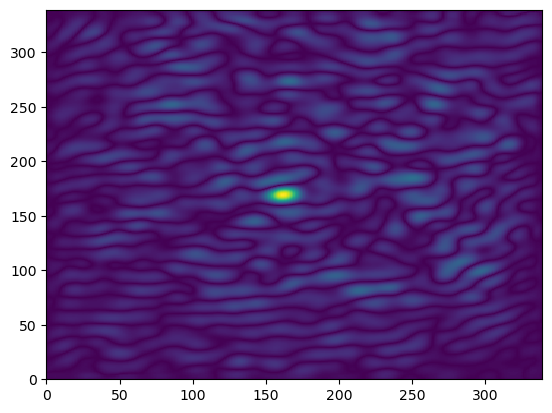

In [17]:
from mathUtils import normxcorr2

C = normxcorr2(t0_curve_grid,t1_curve_grid)
plt.pcolor(C)
C.max()

# Visualize

In [23]:
# Plot alongside the raw images
t0_R = io.imread(path.join(dirname,'0. Day 0/R_reg.tif'))
t1_R = io.imread(path.join(dirname,'1. Day 11/R_reg.tif'))

MIP_t0_R = t0_R.max(axis=0)[Y_trim,X_trim]
MIP_t1_R = t1_R.max(axis=0)[Y_trim,X_trim]